## Demo Experiment for the Language Collapse Methodology

### Part 1: Creating the Collapsed Dataset

Import all necessary libraries/scripts

In [15]:
from transformers import BertConfig
from utils import get_vocab_size, create_base_tokenizer
from matplotlib import pyplot as plt
from transformers import BertForMaskedLM
from bert import MAX_LEN, pad_and_mask, add_mlm_masking, train, get_p_diffs
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import pickle
from generator import create_dataset, get_collapsed_words
from matplotlib.lines import Line2D

Specify collapse factor. Here we collapse the langauge 50%.

In [16]:
COLLAPSE_FACTOR = 1/0.5 # code uses inverse of the more readible factor, 0.5

Load the dataset and original model. Our work is done with the TinyStories dataset and model. Then, extract the embeddings from the model.

In [17]:
dataset = load_dataset('roneneldan/TinyStories')
dataset_train = dataset['train']
dataset_val = dataset['validation']
og_model = AutoModelForCausalLM.from_pretrained('roneneldan/TinyStories-33M')
og_tokenizer = AutoTokenizer.from_pretrained("roneneldan/TinyStories-33M")
embedding_layer = og_model.transformer.wte

Use our algorithm to get the get the collapsed mappings of the dataset. Note that we want to ignore special characters and basic characters (e.g. "a", "!", etc.), hence "ids_to_keep".

In [18]:
token_to_new_id, id_to_new_id = get_collapsed_words(COLLAPSE_FACTOR, og_tokenizer, embedding_layer, use_saved=False, ids_to_keep=list(range(256)) + [-1])

Starting calculating distances
Time taken: 15.981248378753662


Create the new dataset with the mappings found. Note that we need to use the same re-numbered ID mappings to create the validation set, so it is passed in for the second call to create_dataset.

In [19]:
_, id_to_fixed_idx = create_dataset(dataset_train, og_tokenizer, id_to_new_id, og_ds_dir=f"original_dataset.pkl", new_ds_dir=f"new_dataset.pkl")
create_dataset(dataset_val, og_tokenizer, id_to_new_id, id_to_fixed_idx, og_ds_dir=f"original_dataset_val.pkl", new_ds_dir=f"new_dataset_val.pkl");

100%|██████████| 1000/1000 [00:00<00:00, 2331.24it/s]


### Part 2: Experiment on the Collapsed Dataset

Specify the original tokenizer directory to get both vocab sizes.

In [20]:
try:
    original_vocab_size = get_vocab_size("base_tokenizer")
except Exception as e:
    print("Missing tokenizer, downloading the default TinyStories tokenizer.")
    create_base_tokenizer("roneneldan/TinyStories-33M")
    original_vocab_size = get_vocab_size("base_tokenizer")
new_vocab_size = int(original_vocab_size // COLLAPSE_FACTOR)

Load the datasets we just created.

In [21]:
with open("new_dataset.pkl", "rb") as file:
    new_dataset_train = pickle.load(file)
with open("original_dataset.pkl", "rb") as file:
    original_dataset_train = pickle.load(file)
with open("new_dataset_val.pkl", "rb") as file:
    new_dataset_val = pickle.load(file)
with open("original_dataset_val.pkl", "rb") as file:
    original_dataset_val = pickle.load(file)

Prepare the data for the MLM task using our functions.

In [22]:
new_dataset_ids, new_dataset_mask = pad_and_mask(new_dataset_train)
new_dataset_ids, new_dataset_labels = add_mlm_masking(new_dataset_ids, new_vocab_size)
original_dataset_ids, original_dataset_mask = pad_and_mask(original_dataset_train)
original_dataset_ids, original_dataset_labels = add_mlm_masking(original_dataset_ids, original_vocab_size)

new_dataset_val_ids, new_dataset_val_mask = pad_and_mask(new_dataset_val)
new_dataset_val_ids, new_dataset_val_labels = add_mlm_masking(new_dataset_val_ids, new_vocab_size)
original_dataset_val_ids, original_dataset_val_mask = pad_and_mask(original_dataset_val)
original_dataset_val_ids, original_dataset_val_labels = add_mlm_masking(original_dataset_val_ids, original_vocab_size)

Create 4 models to test the method. Here, our architectural change is adjusting the embedding size, as it has the most impact on model performance. We need to have a model of each size on each dataset.

In [23]:
# Smaller, original model on original dataset
bert_config_1 = BertConfig(
    vocab_size=original_vocab_size,
    hidden_size=128,
    num_hidden_layers=2,
    num_attention_heads=2,
    intermediate_size=512,
    max_position_embeddings=MAX_LEN,
)

# Smaller original model on collapsed dataset
bert_config_2 = BertConfig(
    vocab_size=new_vocab_size,
    hidden_size=128,
    num_hidden_layers=2,
    num_attention_heads=2,
    intermediate_size=512,
    max_position_embeddings=MAX_LEN,
)

# Larger new model on original dataset
bert_config_3 = BertConfig(
    vocab_size=original_vocab_size,
    hidden_size=256,
    num_hidden_layers=2,
    num_attention_heads=2,
    intermediate_size=512,
    max_position_embeddings=MAX_LEN,
)

# Larger new model on collapsed dataset
bert_config_4 = BertConfig(
    vocab_size=new_vocab_size,
    hidden_size=256,
    num_hidden_layers=2,
    num_attention_heads=2,
    intermediate_size=512,
    max_position_embeddings=MAX_LEN,
)

Train each model and save the validatation losses.

In [24]:
model = BertForMaskedLM(bert_config_1)
# First is train loss, second is val loss. Only interested in val loss
_, old_d_old_m = train(original_dataset_ids, original_dataset_mask, original_dataset_labels, original_dataset_val_ids, original_dataset_val_mask, original_dataset_val_labels, model, 75, False)

model = BertForMaskedLM(bert_config_2)
_, new_d_old_m = train(new_dataset_ids, new_dataset_mask, new_dataset_labels, new_dataset_val_ids, new_dataset_val_mask, new_dataset_val_labels, model, 75, False)

model = BertForMaskedLM(bert_config_3)
_, old_d_new_m = train(original_dataset_ids, original_dataset_mask, original_dataset_labels, original_dataset_val_ids, original_dataset_val_mask, original_dataset_val_labels, model, 75, False)

model = BertForMaskedLM(bert_config_4)
_, new_d_new_m = train(new_dataset_ids, new_dataset_mask, new_dataset_labels, new_dataset_val_ids, new_dataset_val_mask, new_dataset_val_labels, model, 75, False)

Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda


Plot the results.

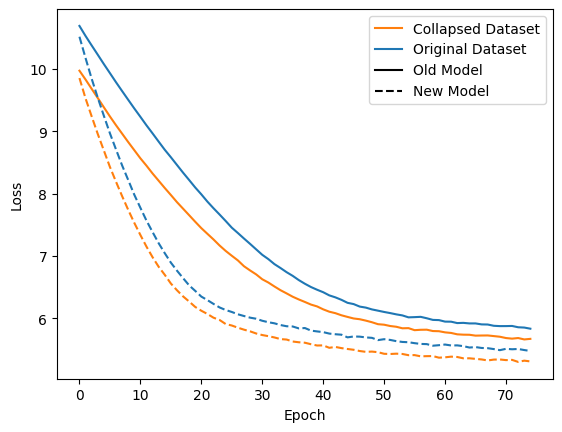

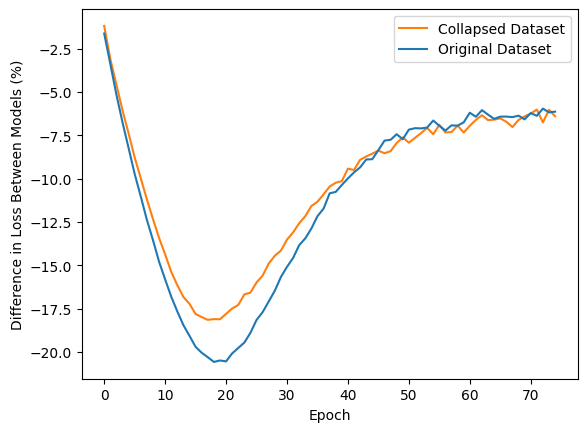

In [25]:
plt.plot(new_d_old_m, label="New Dataset", color="C1")
plt.plot(old_d_old_m, label="Original Dataset", color="C0")
plt.plot(new_d_new_m, color="C1", linestyle="--")
plt.plot(old_d_new_m, color="C0", linestyle="--")
# https://stackoverflow.com/questions/51054529/manipulate-linestyle-in-matplotlib-legend
line = Line2D([0,1],[0,1],linestyle='-', color='C1')
line2 = Line2D([0,1],[0,1],linestyle='-', color='C0')
line3 = Line2D([0,1],[0,1],linestyle='-', color='black')
line4 = Line2D([0,1],[0,1],linestyle='--', color='black')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend([line, line2, line3, line4], ["Collapsed Dataset", "Original Dataset", "Old Model", "New Model"])
plt.show()

p_diffs_new = get_p_diffs(new_d_old_m, new_d_new_m)
p_diffs_old = get_p_diffs(old_d_old_m, old_d_new_m)
plt.plot(p_diffs_new, label="Collapsed Dataset", color="C1")
plt.plot(p_diffs_old, label="Original Dataset", color="C0")
plt.xlabel("Epoch")
plt.ylabel("Difference in Loss Between Models (%)")
plt.legend()
plt.show()